In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import peakutils


/Users/samcohen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



## Generate sine wave data points

In [2]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.4
points_per_cycle = int((2*np.pi) / sample_rate)*10


x_range = np.arange(start=-np.pi/2, stop=60*2*np.pi, step=sample_rate)
print(max(x_range))
mult_start = 0.9
mult_end = 0.7
mult_range = mult_end - mult_start

period_multiplier = np.arange(mult_start, mult_end, mult_range/len(x_range))
#b = np.arange(0.5, 1, 1/len(a))
data = [np.sin(i*j) for i,j in zip(x_range, period_multiplier)]
#Shift the dataset up so we can use -1 as our NaN value
shiftData = [data[i] + -min(data) for i in range(len(data))] 
data = shiftData

print("Total data points: " + str(len(data)))


376.82920367320503
Total data points: 947


## Grab the start and end points of each cycle

In [3]:
#Negate force values to find a trough using the same peak function
negated_vals = [-i for i in data]

#Grab the peak and trough times (these are also indices)
peak_times = peakutils.indexes(data, thres=0.5, min_dist=0.1)
trough_times = peakutils.indexes(negated_vals, thres=0.5, min_dist=0.1)

#Find the time's corresponding y value
peak_vals = [data[i] for i in peak_times]
trough_vals = [data[i] for i in trough_times]

## Generate a dataset using padding

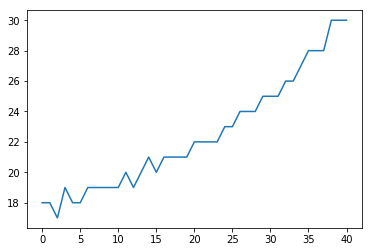

In [4]:
#Collect all the period values from the dataset
periods = []
for i in range(len(trough_times) - 1):
    period = trough_times[i+1] - trough_times[i]
    periods.append(period)
plt.plot(periods)
plt.show()

In [5]:


#Always capture three full waves. A single wave is represented by peak-to-peak. So each example needs a 3 peaks pairs.

#To capture cycles without starting and ending at only peaks each time, 
# use percentages of points realtive to the distance(num points) between the two peaks.
# so if an example starts n points before the first peak, then use n/(n_cyle_points) as the num points to use ahead



"""
Algorithm

3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed
and adding P more points to the end. 


1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time


2. In Loop
    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".
    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    


3.Last stage should just pad each example so they're all of the same dimension
    
    
    Use percentage offset of points from a peak to approximate where to end. 
        (for example that doesnt perfectly capture all peaks)




***Maybe idea is that it should always have at least enough peaks to form n-1 waves and 
extrapolate the rest based on previously seen info

Maybe should always see n peaks, and expand if not

"""





'\nAlgorithm\n\n3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed\nand adding P more points to the end. \n\n\n1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time\n\n\n2. In Loop\n    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".\n    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    \n\n\n3.Last stage should just pad each example so they\'re all of the same dimension\n    \n    \n    Use percentage offset of points from a peak to approximate where to end. \n        (for example that doesnt perfectly capture all peaks)\n\n\n\n\n***Maybe idea is that it should always have at least enough peaks to form n-1 waves and \nextrapolate the rest based on previously seen info\n\nMaybe should always see n peaks, and expand if not\n\n'

## Example generation with pandas dataframe 

In [23]:
def generate_dataset(data, peak_indices, x_cycles=5, y_cycles=1):
    """
    - Each X and label is "set" in size (will contain variable num of useless datapoints at end)
    - So we combine these adjacent to one another and stack all examples vertically 
    TODO: We should make the length grow from the inside out; the prev points should extend backwards?***
    #TODO: Maybe dont split the train inside here, maybe just output a train and test var
    """
    #Set some variables to use
    smallest_period = peak_indices[1] - peak_indices[0]
    largest_period = peak_indices[-1] - peak_indices[-2]
    print("Smallest Period: " + str(smallest_period))
    print("Largest Period: " + str(largest_period))
    period_range = largest_period - smallest_period
    holder_size = int(largest_period * 1.1)
    #holder_size = default_period
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    #Set the variable number of points to use on first iteration
    n_prev = smallest_period * x_cycles
    n_forecast = smallest_period * y_cycles
    
    
    #Init the pandas dataframe to hold our new dataset (TODO!!! probably modularize into seperate function)
    col_names = list()

    for i in range(holder_size*x_cycles, 0, -1):
        col_names += ['var(t-%d)' %  i]
    
    for i in range(0, holder_size*y_cycles):
        if i == 0:
            col_names += ['var(t)']
        else:
            col_names += ['var(t+%d)' % i]

    df = pd.DataFrame(columns = col_names)
    
    print("Just after creation, the df is shape: " + str(df.shape))
    
    #Loop over the data and convert into samples
    for i in range(len(data)):
        #print("----------In Loop: i= "+str(i)+" ---------------------" )
        
        #Exit if we dont have enough points remaining to construct another example
        if((i+n_prev) > len(data) or (i+n_prev+n_forecast) > len(data)):
            print("we're breaking!")
            break
        
        #Init our examples input and label (TODO!!! combine these lines into one as x & y in same row now)
        x = [-1]* (holder_size*x_cycles)
        #print("x size: " +str(len(x)))
        y = [-1]* (holder_size*y_cycles)
        #print("y size: " +str(len(y)))

        #print("X is of size: " + str(len(x)))
        
        #Set real values in the default size holders
        #print("LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        #print(len(x[-n_prev:]))
        #print(len(data[i:i+n_prev]))
        x[-n_prev:] = data[i:i+n_prev] #Store at the end of the array
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast] #Store at the beginning of the array
        
        #Add the x & y pair as a row in the dataframe
        df.loc[i] = x + y 

#         print("x:")
#         print(x)
#         print("length x: "+str(len(x)))
#         print("n_prev (x): " + str(n_prev))
#         print()
#         print("y: ")
#         print(y)
#         print("length y: "+str(len(y)))
#         print("n_forecast (y): " +str(n_forecast))

#         print()
#         print("x+y: ")
#         print(x+y)
#         print()
#         print()
#         print("df.iloc: ")
#         print(df.iloc[i])
        
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        #print("new period size: " + str(new_period_size))
        

    print("num points: " +str(len(data)))
    print("dataframe shape:" + str(df.shape))

    #Set the figure parameters
    fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

    len_final_example = n_prev + n_forecast
    
    #Remeber: iloc works with weird indexing: [rows, cols]
    #First index is rows and second is columns
    train_examples = df.iloc[:-1, :holder_size*x_cycles]
    train_labels = df.iloc[:-1, holder_size*x_cycles:]
    
    test_example = df.iloc[-1, :holder_size*x_cycles]
    test_label = df.iloc[-1, holder_size*x_cycles:]
    
    return train_examples,train_labels, test_example, test_label    

## Building the dataset

In [24]:
# new_exper_data = [i for i in range(30)]
# default_period = 5
# new_exper_peak_times = [0,1,2,4,6,8,11, 13, 16, 18, 21, 25, 30 ]

train_examples, train_labels, test_example, test_label = generate_dataset(data, peak_times)

print("train_examples: " + str(len(train_examples)))
print("train_labels: "+ str(len(train_labels)))
print("test_example: "+ str(len(test_example)))
print("test_label: " + str(len(test_label)))
#print(test_example)
#print(test_label)

Smallest Period: 18
Largest Period: 30
Just after creation, the df is shape: (0, 198)
we're breaking!
num points: 947
dataframe shape:(836, 198)
train_examples: 835
train_labels: 835
test_example: 165
test_label: 33


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [8]:
# fit an LSTM network to training data

def fit_lstm(X, y, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    #X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    #Fit the network to the training data
#     for i in range(nb_epoch):
#         start = timer()
#         print(i)
        
#         model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
#         model.reset_states()
        
#         end = timer()
#         print("Epoch duration: " + str(end - start))


    #Fit the network to the training data
    history = model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    

    return model, architecture, history

In [9]:
#Cut off some training data if necessary for batch sizes
# print()
print(train_examples.shape)
train_examples_cut = train_examples[:-35]
print(train_examples_cut.shape)

print(train_labels.shape)
train_labels_cut = train_labels[:-35]
print(train_labels_cut.shape)


(835, 99)
(800, 99)
(835, 33)
(800, 33)


## Train the Neural Network

In [10]:
n_epochs = 500
n_batch = 50
n_neurons = 30
#print("train shape: " + str(train.shape))
#train_cut = train[:-2,:]
#train_cut = train
#print("train shape: " + str(train_cut.shape))
train = train_examples_cut.values
print("train shape: " +str(train.shape))
model, architecture, history = fit_lstm(train, train_labels_cut.values, n_batch, n_epochs, n_neurons)


train shape: (800, 99)
X shape: (800, 99)
y shape: (800, 33)
sam
(50, 99, 1)
(800, 99, 1)
Epoch 1/500
800/800 [==============================] - 2s 2ms/step - loss: 1.2566 - acc: 0.0512
Epoch 2/500
800/800 [==============================] - 1s 1ms/step - loss: 1.0029 - acc: 0.0562
Epoch 3/500
800/800 [==============================] - 1s 1ms/step - loss: 0.6989 - acc: 0.0787
Epoch 4/500
800/800 [==============================] - 1s 1ms/step - loss: 0.5798 - acc: 0.0937
Epoch 5/500
800/800 [==============================] - 1s 1ms/step - loss: 0.5429 - acc: 0.0537
Epoch 6/500
800/800 [==============================] - 1s 1ms/step - loss: 0.5296 - acc: 0.0775
Epoch 7/500
800/800 [==============================] - 1s 1ms/step - loss: 0.5202 - acc: 0.1175
Epoch 8/500
800/800 [==============================] - 1s 1ms/step - loss: 0.5084 - acc: 0.1188
Epoch 9/500
800/800 [==============================] - 1s 1ms/step - loss: 0.4964 - acc: 0.1038
Epoch 10/500
800/800 [========================

800/800 [==============================] - 1s 1ms/step - loss: 0.2907 - acc: 0.1700
Epoch 84/500
800/800 [==============================] - 1s 1ms/step - loss: 0.2324 - acc: 0.1812
Epoch 85/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1555 - acc: 0.2763
Epoch 86/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1634 - acc: 0.3225
Epoch 87/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1390 - acc: 0.2900A: 0s - loss: 0.1736 -  - ETA: 0s - loss: 0.1360 - acc: 0.294
Epoch 88/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1297 - acc: 0.3575
Epoch 89/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1207 - acc: 0.3875
Epoch 90/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1249 - acc: 0.2850
Epoch 91/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1116 - acc: 0.3575
Epoch 92/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1

800/800 [==============================] - 1s 1ms/step - loss: 0.0792 - acc: 0.4338
Epoch 166/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1078 - acc: 0.3387
Epoch 167/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1247 - acc: 0.3488
Epoch 168/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0952 - acc: 0.3750
Epoch 169/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1369 - acc: 0.2725
Epoch 170/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1327 - acc: 0.3025
Epoch 171/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1003 - acc: 0.3587
Epoch 172/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1174 - acc: 0.2838
Epoch 173/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1070 - acc: 0.3950
Epoch 174/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1026 - acc: 0.3337
Epoch 175/500
800/800 [===========

800/800 [==============================] - 1s 1ms/step - loss: 0.0807 - acc: 0.3512
Epoch 248/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0869 - acc: 0.4575
Epoch 249/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0781 - acc: 0.3738
Epoch 250/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0760 - acc: 0.3500
Epoch 251/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0860 - acc: 0.4225
Epoch 252/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0818 - acc: 0.4325
Epoch 253/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1138 - acc: 0.2625
Epoch 254/500
800/800 [==============================] - 1s 1ms/step - loss: 0.1196 - acc: 0.4013
Epoch 255/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0875 - acc: 0.3513
Epoch 256/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0778 - acc: 0.4225
Epoch 257/500
800/800 [===========

800/800 [==============================] - 1s 1ms/step - loss: 0.0582 - acc: 0.4950
Epoch 331/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0546 - acc: 0.4538
Epoch 332/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0546 - acc: 0.4637
Epoch 333/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0569 - acc: 0.4788
Epoch 334/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0617 - acc: 0.4250
Epoch 335/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0655 - acc: 0.4238
Epoch 336/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0799 - acc: 0.4887
Epoch 337/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0764 - acc: 0.4025
Epoch 338/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0608 - acc: 0.4425
Epoch 339/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0640 - acc: 0.4600
Epoch 340/500
800/800 [===========

800/800 [==============================] - 1s 1ms/step - loss: 0.0559 - acc: 0.5537
Epoch 413/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0594 - acc: 0.4950
Epoch 414/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0554 - acc: 0.4588
Epoch 415/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0750 - acc: 0.5025
Epoch 416/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0698 - acc: 0.4475
Epoch 417/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0568 - acc: 0.4475
Epoch 418/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0609 - acc: 0.5187A: 0s - loss: 0.0626 - acc: 0.5
Epoch 419/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0668 - acc: 0.4388
Epoch 420/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0474 - acc: 0.5000
Epoch 421/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0524 - acc: 0.5700
Epo

800/800 [==============================] - 1s 1ms/step - loss: 0.0549 - acc: 0.5312A: 0s - loss: 0.0634 
Epoch 495/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0513 - acc: 0.5038
Epoch 496/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0491 - acc: 0.5288
Epoch 497/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0483 - acc: 0.5812
Epoch 498/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0534 - acc: 0.5112
Epoch 499/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0515 - acc: 0.5388
Epoch 500/500
800/800 [==============================] - 1s 1ms/step - loss: 0.0478 - acc: 0.5487


## Display training progress

dict_keys(['loss', 'acc'])


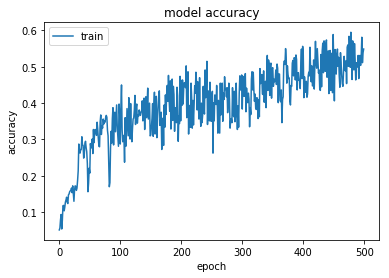

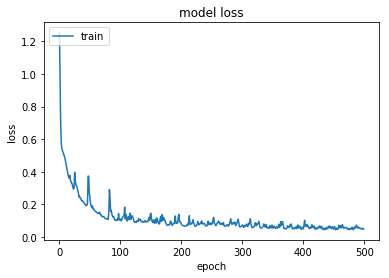

In [11]:
#list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [13]:
#Run on test data
#test_x, test_y = test[0:n_prev], test[n_prev:]
test_x, test_y = test_example.values, test_label.values
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(33):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

99
(50, 99)
First true label: 1.6992343449598946
First forecast: 1.7258651
Average RMSE: 
0.40911685635619394


## Plotting initial training data

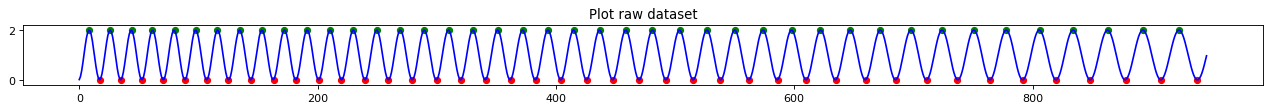

1.9997692280824264


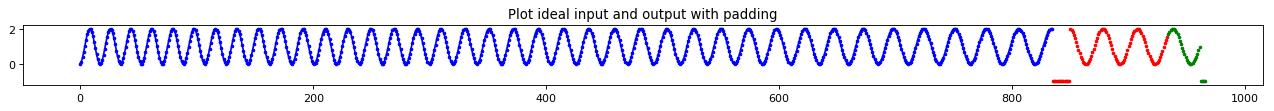

hi
835


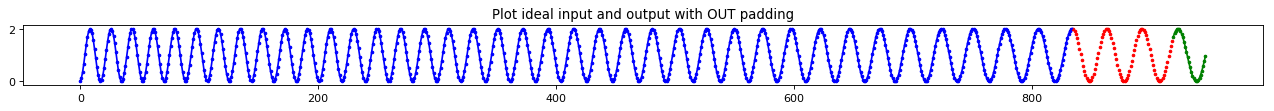

hi
28
28
24
24
33


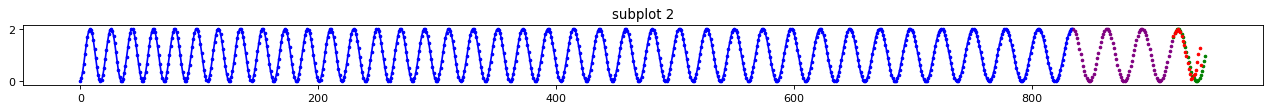

In [22]:
# (1) Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")
plt.title('Plot raw dataset')

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)
plt.show()

# (2)--------------------------------------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with padding')

#Grab the data without padding
test_in_raw = test_example.values 
test_in = [test_in_raw[i] for i in range(len(test_in_raw)) if test_in_raw[i] >= 0]
test_out_raw = test_label.values
test_out = [test_out_raw[i] for i in range(len(test_out_raw)) if test_out_raw[i] >= 0]
test_len = len(test_in) + len(test_out) #default_period * 4

print(max(test_in))


#Plot the training data and the underlying curve in blue 
train_plot_points= data[:-test_len]
plt.plot(train_plot_points, color="blue")
train_plot_x = [x for x in range(len(train_plot_points))]
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red
test_input_plot_points = test_example.values
test_input_xs = [x +len(train_plot_points) for x in range(len(test_input_plot_points))]
plt.scatter(test_input_xs, test_input_plot_points, color="red", s=5)

#Plot the test target label in green
test_label_points = test_label.values
test_label_xs = [x +(len(train_plot_points)+len(test_input_plot_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=5)
plt.show()
print("hi")

# (3)--------------------To better visualize, we can also remove the unused padding-----------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with OUT padding')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
test_in_xs = [x +len(train_plot_points) for x in range(len(test_in))]
print(min(test_in_xs))
plt.scatter(test_in_xs, test_in, color="red", s=5)
#plt.plot(test_in, test_in_xs, color="red")

#Plot the test target label in green (no padding)
test_label_xs = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(test_out))]
plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.plot(test_label_xs, test_out, color="green")
plt.show()
print("hi")





# (4)----Plot the actual results----------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.title('subplot 2')
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
plt.scatter(test_in_xs, test_in, color="purple", s=5)


#Plot the test target label in green (no padding)

#Remove padding from the prediction
y_hat_nopad = [y_hat[i] for i in range(len(y_hat)) if y_hat[i] >= 0]

test_label_xs2 = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(y_hat_nopad))]
print(len(test_label_xs))
print(len(test_out))

print(len(test_label_xs2))
print(len(y_hat_nopad))

plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.scatter(test_label_xs2, y_hat_nopad, color="red", s=5)

#plt.plot(y_hat, test_label_xs, color="green")




print(len(y_hat))




## Varify that the network learned to increase period

In [16]:
#In a way we can just treat the number of non-negative points as the length of the period

init_period = periods[0]

print("Init period: " + str(init_period))
print("True holder size " + str(len(test_out_raw)))
print("True period size: " + str(len(test_out)))

print("Predicted holder size: "+str(len(y_hat)))
print("Predicted period size: "+str(len(y_hat_nopad)))




Init period: 18
True holder size 33
True period size: 28
Predicted holder size: 33
Predicted period size: 24


## Evaluate the forecast based on its RMSE and record results

In [17]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


NameError: name 'n_forecast' is not defined

## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

In [ ]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

In [ ]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
 
model = Sequential()
model.add(LSTM(2, input_shape=(2,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
 
x= np.array([[[1],[2]],[[3],[4]],[[5],[6]],[[7],[8]]])
y = np.array([1,2,3,4])
 
model.fit(x, y, nb_epoch=10, batch_size=2, verbose=1)


In [ ]:
print(model.predict([[[1],[3]], [[2],[4]], [[3],[5]]], batch_size=3))

In [ ]:
a = [1,2,3]
b = np.stack((a,a,a))
print(b.shape)